In [2]:
# 코랩 환경에서 작업 (쥬피터에서 실행시 주석처리)
from google.colab import drive
import os
drive.mount('/content/drive')
# # Colab Notebooks 안에 my_env 폴더에 패키지 저장
# import os 
# my_path = '/content/notebooks'
# os.symlink('/content/drive/My Drive/jeong-term/my_env', my_path)
# sys.path.insert(0, my_path)
os.chdir("/content/drive/MyDrive/jeong-term/공공자전거데이터")

Mounted at /content/drive


In [2]:


############################################## 00. 필요한 파이썬 라이브러리 불러오기 #####################################################
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import folium
import webbrowser

import sys
import plotly
import plotly.graph_objects as go
import plotly.express as px
# from numpy import random
import missingno

# import spark
import pydot 
from IPython.display import Image
import pyarrow as pa

import json
import urllib
import math
from tqdm import tqdm
import warnings
import time
from datetime import datetime
import itertools

## 전처리 ## 
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, r2_score
from sklearn.linear_model import LogisticRegression
from sklearn import tree 
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

## 시계열 실습 ##
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf   ### acf pacf 그래프 생성 도구
# from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
# from pmdarima.arima import auto_arima   ## arima 모델의 최적화된 계수를 알려줌
from statsmodels.tsa.stattools import adfuller

import tensorflow_probability as tfp
from tensorflow_probability import sts

# ## 자체적으로 만든 모듈
# from bike_data_analysis import *

################### 설정 ########################
warnings.filterwarnings(action='ignore')
pd.options.display.float_format = '{:.2f}'.format
plt.style.use('seaborn-whitegrid')
%matplotlib inline

Text(0.3, 0.3, '한글')

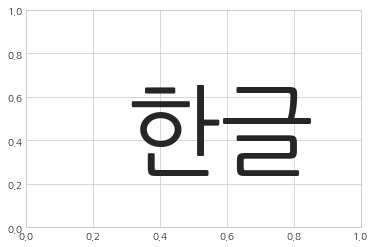

In [51]:
#한글 폰트 사용
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import font_manager,rc

#폰트 경로
font_path = "C:/Windows/Fonts/NanumGothic.TTF"

#폰트 이름 얻어오기
font_name = font_manager.FontProperties(fname=font_path).get_name()

#font 설정
plt.rc('font', family=font_name)

#시범 출력
plt.text(0.3, 0.3, '한글', size=100)

In [53]:
labeled_input_bike_df = pd.read_parquet("labeled_input_bike_df.parquet")

labeled_input_bike_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8760 entries, 2021-01-01 00:00:00 to 2021-12-31 23:00:00
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   대여월      8760 non-null   int64  
 1   대여요일     8760 non-null   int32  
 2   대여시각     8760 non-null   int64  
 3   대여계절     8760 non-null   int32  
 4   1시간강수량   8760 non-null   float64
 5   1시간전대여량  8760 non-null   int64  
 6   대여량      8760 non-null   int64  
dtypes: float64(1), int32(2), int64(4)
memory usage: 479.1 KB


In [5]:
## auto-arima for 1yr-exod, differencing?, 1시간전 대여량 추가 
data = labeled_input_bike_df
X_train,X_test,y_train,y_test = train_test_split(data.iloc[:,:-1],data["대여량"],test_size=0.2,shuffle=False)
# auto_arima(y_train,exogeneous=X_train,max_p=5,max_q=5,seasonal=True, max_P=5,max_Q=5,m=24,trace=True,suppress_warnings=True,stepwise=False)

AIC_list = {}
for j in range(25):
    try:
        (p,P,q,Q) = (24,24,j,j)
        
        # 모델 생성
        model = SARIMAX(endog = y_train,exog=X_train, order=(p,0,q),sorder=(P,0,Q,24))  ##<< auto_arima에서 최적 parameter 사용

        # 예측값 반환
        predicted_value,AIC = model_prediction_v2(model,y_test)
        AIC_list[(p,q)]=AIC
        print(f"AIC score for (p,q) tuple{(p,q)} --> {AIC_list[(p,q)]:.2f}")

    except:
        print("Error occured")
        continue

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                    대여량   No. Observations:                 7008
Model:              SARIMAX(24, 0, 0)   Log Likelihood              -33400.023
Date:                Tue, 07 Jun 2022   AIC                          66862.046
Time:                        15:54:51   BIC                          67074.545
Sample:                    01-01-2021   HQIC                         66935.265
                         - 10-19-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
대여월            3.3202      0.319     10.399      0.000       2.694       3.946
대여요일           0.6160      0.179      3.432      0.001       0.264       0.968
대여시각           0.0269      0.154      0.175      0.861      -0.275       0.328
대여계절           2.3736      0.592      4.009      0.000       1.213       3.534
1시간강수량        -6.1328      0.227    -27.048      0.000      -6.577      -5.688
1시간전대여량        0.7619      0.009     80.568      0.000       0.743       0.780
ar.L1          0.1692      0.013     13.477      0.000       0.145       0.194
ar.L2          0.0523      0.011      4.620      0.000       0.030       0.074
ar.L3          0.0371      0.011      3.313      0.001       0.015       0.059
ar.L4          0.0532      0.011      4.862      0.000       0.032       0.075
ar.L5         -0.0326      0.012     -2.761      0.006      -0.056      -0.009
ar.L6         -0.0514      0.012     -4.298      0.000      -0.075      -0.028
ar.L7         -0.0637      0.013     -4.993      0.000      -0.089      -0.039
ar.L8         -0.0781      0.012     -6.580      0.000      -0.101      -0.055
ar.L9         -0.0601      0.011     -5.484      0.000      -0.082      -0.039
ar.L10         0.1543      0.011     14.316      0.000       0.133       0.175
ar.L11         0.0137      0.011      1.199      0.230      -0.009       0.036
ar.L12        -0.0727      0.011     -6.909      0.000      -0.093      -0.052
ar.L13        -0.0268      0.010     -2.611      0.009      -0.047      -0.007
ar.L14         0.0630      0.010      6.437      0.000       0.044       0.082
ar.L15        -0.0687      0.010     -6.642      0.000      -0.089      -0.048
ar.L16        -0.0481      0.012     -4.157      0.000      -0.071      -0.025
ar.L17        -0.0334      0.012     -2.703      0.007      -0.058      -0.009
ar.L18         0.0177      0.011      1.583      0.113      -0.004       0.040
ar.L19         0.0139      0.011      1.311      0.190      -0.007       0.035
ar.L20         0.0272      0.011      2.556      0.011       0.006       0.048
ar.L21        -0.0053      0.011     -0.467      0.640      -0.027       0.017
ar.L22         0.0124      0.010      1.225      0.221      -0.007       0.032
ar.L23         0.0953      0.009     10.598      0.000       0.078       0.113
ar.L24         0.4082      0.009     47.917      0.000       0.392       0.425
sigma2       812.1152      8.978     90.456      0.000     794.519     829.712
===================================================================================
Ljung-Box (Q):                      154.92   Jarque-Bera (JB):              5113.28
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               3.16   Skew:                            -0.22
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using t

AIC : 66862.0459134015
rmse score is : 34.53648873732405
AIC score for (p,q) tuple(24, 0) --> 66862.05


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                    대여량   No. Observations:                 7008
Model:              SARIMAX(24, 0, 1)   Log Likelihood              -33399.288
Date:                Tue, 07 Jun 2022   AIC                          66862.576
Time:                        15:59:58   BIC                          67081.930
Sample:                    01-01-2021   HQIC                         66938.157
                         - 10-19-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
대여월            2.1064      0.249      8.449      0.000       1.618       2.595
대여요일           0.1850      0.143      1.294      0.196      -0.095       0.465
대여시각           0.2508      0.126      1.985      0.047       0.003       0.498
대여계절           1.9790      0.396      4.992      0.000       1.202       2.756
1시간강수량        -6.1229      0.219    -28.012      0.000      -6.551      -5.695
1시간전대여량        0.8243      0.011     72.129      0.000       0.802       0.847
ar.L1          0.2264      0.023     10.027      0.000       0.182       0.271
ar.L2         -0.0007      0.014     -0.049      0.961      -0.027       0.026
ar.L3          0.0081      0.012      0.675      0.500      -0.015       0.032
ar.L4          0.0361      0.012      3.142      0.002       0.014       0.059
ar.L5         -0.0486      0.012     -3.990      0.000      -0.072      -0.025
ar.L6         -0.0523      0.013     -4.183      0.000      -0.077      -0.028
ar.L7         -0.0666      0.013     -5.026      0.000      -0.093      -0.041
ar.L8         -0.0838      0.012     -6.778      0.000      -0.108      -0.060
ar.L9         -0.0616      0.012     -5.312      0.000      -0.084      -0.039
ar.L10         0.1444      0.012     12.536      0.000       0.122       0.167
ar.L11        -0.0194      0.013     -1.497      0.134      -0.045       0.006
ar.L12        -0.0742      0.011     -6.750      0.000      -0.096      -0.053
ar.L13        -0.0276      0.011     -2.570      0.010      -0.049      -0.007
ar.L14         0.0544      0.010      5.322      0.000       0.034       0.074
ar.L15        -0.0853      0.011     -7.636      0.000      -0.107      -0.063
ar.L16        -0.0455      0.012     -3.784      0.000      -0.069      -0.022
ar.L17        -0.0326      0.013     -2.552      0.011      -0.058      -0.008
ar.L18         0.0171      0.012      1.459      0.144      -0.006       0.040
ar.L19         0.0037      0.011      0.339      0.735      -0.018       0.025
ar.L20         0.0148      0.011      1.359      0.174      -0.007       0.036
ar.L21        -0.0221      0.012     -1.894      0.058      -0.045       0.001
ar.L22         0.0054      0.011      0.513      0.608      -0.015       0.026
ar.L23         0.0820      0.009      8.982      0.000       0.064       0.100
ar.L24         0.3990      0.009     42.714      0.000       0.381       0.417
ma.L1         -0.1393      0.027     -5.146      0.000      -0.192      -0.086
sigma2       813.4100      9.014     90.235      0.000     795.742     831.078
===================================================================================
Ljung-Box (Q):                      159.73   Jarque-Bera (JB):              4871.46
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               3.21   Skew:                            -0.18
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.07
========================================================

AIC : 66862.57588073084
rmse score is : 29.695443188249882
AIC score for (p,q) tuple(24, 1) --> 66862.58


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                    대여량   No. Observations:                 7008
Model:              SARIMAX(24, 0, 2)   Log Likelihood              -33397.926
Date:                Tue, 07 Jun 2022   AIC                          66861.852
Time:                        16:05:36   BIC                          67088.061
Sample:                    01-01-2021   HQIC                         66939.795
                         - 10-19-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
대여월            2.0634      0.252      8.204      0.000       1.570       2.556
대여요일           0.1922      0.131      1.463      0.143      -0.065       0.450
대여시각           0.1945      0.122      1.595      0.111      -0.045       0.434
대여계절           1.9749      0.380      5.196      0.000       1.230       2.720
1시간강수량        -6.1063      0.222    -27.484      0.000      -6.542      -5.671
1시간전대여량        0.8343      0.012     68.504      0.000       0.810       0.858
ar.L1          0.2036      0.028      7.240      0.000       0.148       0.259
ar.L2          0.0937      0.029      3.192      0.001       0.036       0.151
ar.L3         -0.0111      0.013     -0.871      0.384      -0.036       0.014
ar.L4          0.0298      0.011      2.610      0.009       0.007       0.052
ar.L5         -0.0529      0.012     -4.419      0.000      -0.076      -0.029
ar.L6         -0.0633      0.013     -5.013      0.000      -0.088      -0.039
ar.L7         -0.0638      0.013     -4.816      0.000      -0.090      -0.038
ar.L8         -0.0833      0.012     -6.742      0.000      -0.108      -0.059
ar.L9         -0.0607      0.012     -5.258      0.000      -0.083      -0.038
ar.L10         0.1544      0.011     13.531      0.000       0.132       0.177
ar.L11        -0.0077      0.014     -0.572      0.567      -0.034       0.019
ar.L12        -0.0951      0.012     -7.804      0.000      -0.119      -0.071
ar.L13        -0.0286      0.011     -2.591      0.010      -0.050      -0.007
ar.L14         0.0621      0.010      5.955      0.000       0.042       0.083
ar.L15        -0.0855      0.011     -7.620      0.000      -0.108      -0.064
ar.L16        -0.0583      0.013     -4.535      0.000      -0.083      -0.033
ar.L17        -0.0265      0.013     -2.068      0.039      -0.052      -0.001
ar.L18         0.0257      0.012      2.163      0.031       0.002       0.049
ar.L19         0.0088      0.011      0.807      0.420      -0.013       0.030
ar.L20         0.0150      0.011      1.385      0.166      -0.006       0.036
ar.L21        -0.0186      0.012     -1.598      0.110      -0.042       0.004
ar.L22        -0.0028      0.011     -0.262      0.793      -0.024       0.018
ar.L23         0.0848      0.009      9.233      0.000       0.067       0.103
ar.L24         0.3907      0.009     41.895      0.000       0.372       0.409
ma.L1         -0.1264      0.030     -4.254      0.000      -0.185      -0.068
ma.L2         -0.1183      0.031     -3.880      0.000      -0.178      -0.059
sigma2       812.9857      9.020     90.129      0.000     795.306     830.665
===================================================================================
Ljung-Box (Q):                      166.68   Jarque-Bera (JB):              4742.00
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               3.18   Skew:                            -0.21
Prob(H) (two-sided):                  0.00   Kurtosis:       

AIC : 66861.85199899375
rmse score is : 29.522024956476596
AIC score for (p,q) tuple(24, 2) --> 66861.85


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                    대여량   No. Observations:                 7008
Model:              SARIMAX(24, 0, 3)   Log Likelihood              -33387.701
Date:                Tue, 07 Jun 2022   AIC                          66843.403
Time:                        16:10:58   BIC                          67076.466
Sample:                    01-01-2021   HQIC                         66923.708
                         - 10-19-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
대여월            1.8027      0.243      7.409      0.000       1.326       2.280
대여요일           0.0642      0.117      0.548      0.584      -0.165       0.294
대여시각           0.2160      0.126      1.709      0.087      -0.032       0.464
대여계절           1.8549      0.396      4.683      0.000       1.079       2.631
1시간강수량        -6.1230      0.217    -28.179      0.000      -6.549      -5.697
1시간전대여량        0.8506      0.011     75.999      0.000       0.829       0.873
ar.L1          0.3095      0.030     10.402      0.000       0.251       0.368
ar.L2         -0.0763      0.037     -2.091      0.037      -0.148      -0.005
ar.L3          0.1764      0.029      6.033      0.000       0.119       0.234
ar.L4          0.0019      0.012      0.151      0.880      -0.022       0.026
ar.L5         -0.0599      0.012     -4.823      0.000      -0.084      -0.036
ar.L6         -0.0539      0.013     -4.046      0.000      -0.080      -0.028
ar.L7         -0.0762      0.014     -5.475      0.000      -0.103      -0.049
ar.L8         -0.0708      0.013     -5.453      0.000      -0.096      -0.045
ar.L9         -0.0500      0.012     -4.124      0.000      -0.074      -0.026
ar.L10         0.1693      0.012     14.235      0.000       0.146       0.193
ar.L11        -0.0150      0.015     -1.026      0.305      -0.044       0.014
ar.L12        -0.0476      0.014     -3.399      0.001      -0.075      -0.020
ar.L13        -0.0456      0.012     -3.844      0.000      -0.069      -0.022
ar.L14         0.0562      0.011      5.074      0.000       0.035       0.078
ar.L15        -0.0846      0.012     -7.054      0.000      -0.108      -0.061
ar.L16        -0.0251      0.014     -1.798      0.072      -0.052       0.002
ar.L17        -0.0520      0.014     -3.697      0.000      -0.080      -0.024
ar.L18         0.0417      0.012      3.428      0.001       0.018       0.066
ar.L19         0.0176      0.011      1.545      0.122      -0.005       0.040
ar.L20         0.0356      0.012      3.076      0.002       0.013       0.058
ar.L21        -0.0189      0.012     -1.545      0.122      -0.043       0.005
ar.L22         0.0047      0.011      0.414      0.679      -0.017       0.027
ar.L23         0.0782      0.010      7.869      0.000       0.059       0.098
ar.L24         0.3750      0.010     36.261      0.000       0.355       0.395
ma.L1         -0.2593      0.032     -8.211      0.000      -0.321      -0.197
ma.L2          0.0420      0.036      1.158      0.247      -0.029       0.113
ma.L3         -0.2071      0.030     -6.907      0.000      -0.266      -0.148
sigma2       813.8197      9.018     90.243      0.000     796.145     831.495
===================================================================================
Ljung-Box (Q):                      153.79   Jarque-Bera (JB):              4674.78
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               3.18   Skew:                

AIC : 66843.40251464413
rmse score is : 28.60852348481675
AIC score for (p,q) tuple(24, 3) --> 66843.40


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                    대여량   No. Observations:                 7008
Model:              SARIMAX(24, 0, 4)   Log Likelihood              -33372.634
Date:                Tue, 07 Jun 2022   AIC                          66815.268
Time:                        16:16:53   BIC                          67055.186
Sample:                    01-01-2021   HQIC                         66897.935
                         - 10-19-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
대여월            1.7599      0.234      7.526      0.000       1.302       2.218
대여요일           0.0933      0.110      0.851      0.395      -0.122       0.308
대여시각           0.1538      0.124      1.242      0.214      -0.089       0.396
대여계절           1.8400      0.372      4.940      0.000       1.110       2.570
1시간강수량        -6.1096      0.214    -28.569      0.000      -6.529      -5.690
1시간전대여량        0.8595      0.011     79.334      0.000       0.838       0.881
ar.L1          0.2229      0.029      7.767      0.000       0.167       0.279
ar.L2          0.0157      0.034      0.456      0.648      -0.052       0.083
ar.L3          0.0253      0.035      0.721      0.471      -0.044       0.094
ar.L4          0.1545      0.028      5.479      0.000       0.099       0.210
ar.L5         -0.0799      0.012     -6.447      0.000      -0.104      -0.056
ar.L6         -0.0651      0.013     -5.120      0.000      -0.090      -0.040
ar.L7         -0.0719      0.014     -5.312      0.000      -0.098      -0.045
ar.L8         -0.0851      0.013     -6.748      0.000      -0.110      -0.060
ar.L9         -0.0568      0.012     -4.919      0.000      -0.079      -0.034
ar.L10         0.1615      0.012     14.012      0.000       0.139       0.184
ar.L11         0.0033      0.014      0.233      0.816      -0.024       0.031
ar.L12        -0.0616      0.013     -4.574      0.000      -0.088      -0.035
ar.L13        -0.0176      0.013     -1.325      0.185      -0.044       0.008
ar.L14         0.0323      0.011      2.876      0.004       0.010       0.054
ar.L15        -0.0824      0.012     -7.022      0.000      -0.105      -0.059
ar.L16        -0.0287      0.013     -2.145      0.032      -0.055      -0.002
ar.L17        -0.0327      0.014     -2.341      0.019      -0.060      -0.005
ar.L18         0.0023      0.013      0.183      0.855      -0.023       0.028
ar.L19         0.0243      0.011      2.169      0.030       0.002       0.046
ar.L20         0.0345      0.011      3.001      0.003       0.012       0.057
ar.L21        -0.0063      0.012     -0.507      0.612      -0.030       0.018
ar.L22         0.0064      0.011      0.577      0.564      -0.015       0.028
ar.L23         0.0861      0.010      8.861      0.000       0.067       0.105
ar.L24         0.3876      0.010     39.717      0.000       0.368       0.407
ma.L1         -0.1720      0.030     -5.672      0.000      -0.231      -0.113
ma.L2         -0.0512      0.035     -1.481      0.139      -0.119       0.017
ma.L3         -0.0571      0.036     -1.604      0.109      -0.127       0.013
ma.L4         -0.1681      0.028     -5.906      0.000      -0.224      -0.112
sigma2       812.0228      8.993     90.292      0.000     794.396     829.649
===================================================================================
Ljung-Box (Q):                      128.47   Jarque-Bera (JB):              4944.52
Prob(Q):                              0.00   Prob(JB):                 

AIC : 66815.26814114983
rmse score is : 28.40843471143086
AIC score for (p,q) tuple(24, 4) --> 66815.27


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                    대여량   No. Observations:                 7008
Model:              SARIMAX(24, 0, 5)   Log Likelihood              -33372.393
Date:                Tue, 07 Jun 2022   AIC                          66816.785
Time:                        16:22:30   BIC                          67063.559
Sample:                    01-01-2021   HQIC                         66901.815
                         - 10-19-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
대여월            1.7552      0.235      7.469      0.000       1.295       2.216
대여요일           0.0998      0.109      0.917      0.359      -0.113       0.313
대여시각           0.1537      0.127      1.214      0.225      -0.094       0.402
대여계절           1.8362      0.376      4.885      0.000       1.099       2.573
1시간강수량        -6.1091      0.214    -28.510      0.000      -6.529      -5.689
1시간전대여량        0.8596      0.011     78.919      0.000       0.838       0.881
ar.L1          0.2182      0.029      7.506      0.000       0.161       0.275
ar.L2          0.0207      0.035      0.599      0.549      -0.047       0.088
ar.L3          0.0299      0.035      0.847      0.397      -0.039       0.099
ar.L4          0.1281      0.033      3.850      0.000       0.063       0.193
ar.L5         -0.0500      0.031     -1.627      0.104      -0.110       0.010
ar.L6         -0.0665      0.013     -4.944      0.000      -0.093      -0.040
ar.L7         -0.0719      0.013     -5.342      0.000      -0.098      -0.046
ar.L8         -0.0860      0.013     -6.860      0.000      -0.111      -0.061
ar.L9         -0.0596      0.012     -5.046      0.000      -0.083      -0.036
ar.L10         0.1605      0.011     14.023      0.000       0.138       0.183
ar.L11         0.0065      0.014      0.463      0.643      -0.021       0.034
ar.L12        -0.0594      0.014     -4.391      0.000      -0.086      -0.033
ar.L13        -0.0154      0.013     -1.161      0.246      -0.041       0.011
ar.L14         0.0399      0.013      3.184      0.001       0.015       0.065
ar.L15        -0.0867      0.012     -7.200      0.000      -0.110      -0.063
ar.L16        -0.0351      0.013     -2.608      0.009      -0.062      -0.009
ar.L17        -0.0300      0.014     -2.131      0.033      -0.058      -0.002
ar.L18         0.0086      0.013      0.669      0.504      -0.017       0.034
ar.L19         0.0216      0.012      1.795      0.073      -0.002       0.045
ar.L20         0.0346      0.011      3.015      0.003       0.012       0.057
ar.L21        -0.0039      0.012     -0.315      0.753      -0.028       0.020
ar.L22         0.0070      0.011      0.626      0.532      -0.015       0.029
ar.L23         0.0844      0.010      8.803      0.000       0.066       0.103
ar.L24         0.3883      0.010     39.736      0.000       0.369       0.407
ma.L1         -0.1697      0.031     -5.540      0.000      -0.230      -0.110
ma.L2         -0.0587      0.035     -1.694      0.090      -0.127       0.009
ma.L3         -0.0616      0.036     -1.713      0.087      -0.132       0.009
ma.L4         -0.1395      0.034     -4.151      0.000      -0.205      -0.074
ma.L5         -0.0304      0.031     -0.989      0.322      -0.091       0.030
sigma2       812.1481      9.000     90.238      0.000     794.508     829.788
===================================================================================
Ljung-Box (Q):                      122.15   Jarque-Bera (JB):              

AIC : 66816.78542641473
rmse score is : 28.410982714415894
AIC score for (p,q) tuple(24, 5) --> 66816.79


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                    대여량   No. Observations:                 7008
Model:              SARIMAX(24, 0, 6)   Log Likelihood              -33368.376
Date:                Tue, 07 Jun 2022   AIC                          66810.752
Time:                        16:28:33   BIC                          67064.380
Sample:                    01-01-2021   HQIC                         66898.143
                         - 10-19-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
대여월            1.7328      0.237      7.301      0.000       1.268       2.198
대여요일           0.0873      0.107      0.813      0.416      -0.123       0.298
대여시각           0.1563      0.129      1.214      0.225      -0.096       0.409
대여계절           1.8238      0.383      4.765      0.000       1.074       2.574
1시간강수량        -6.1120      0.213    -28.730      0.000      -6.529      -5.695
1시간전대여량        0.8602      0.011     77.740      0.000       0.839       0.882
ar.L1          0.2550      0.031      8.278      0.000       0.195       0.315
ar.L2         -0.0195      0.036     -0.542      0.588      -0.090       0.051
ar.L3          0.0077      0.035      0.221      0.825      -0.061       0.076
ar.L4          0.1891      0.033      5.788      0.000       0.125       0.253
ar.L5         -0.1698      0.036     -4.689      0.000      -0.241      -0.099
ar.L6          0.0513      0.034      1.519      0.129      -0.015       0.118
ar.L7         -0.0830      0.014     -5.803      0.000      -0.111      -0.055
ar.L8         -0.0908      0.013     -7.101      0.000      -0.116      -0.066
ar.L9         -0.0523      0.012     -4.315      0.000      -0.076      -0.029
ar.L10         0.1477      0.012     12.115      0.000       0.124       0.172
ar.L11        -0.0052      0.014     -0.363      0.716      -0.033       0.023
ar.L12        -0.0547      0.014     -3.960      0.000      -0.082      -0.028
ar.L13        -0.0064      0.014     -0.467      0.640      -0.033       0.021
ar.L14         0.0294      0.013      2.302      0.021       0.004       0.055
ar.L15        -0.0597      0.014     -4.385      0.000      -0.086      -0.033
ar.L16        -0.0392      0.014     -2.803      0.005      -0.067      -0.012
ar.L17        -0.0383      0.014     -2.687      0.007      -0.066      -0.010
ar.L18         0.0092      0.013      0.706      0.480      -0.016       0.035
ar.L19         0.0348      0.012      2.829      0.005       0.011       0.059
ar.L20         0.0142      0.013      1.100      0.272      -0.011       0.039
ar.L21        -0.0003      0.013     -0.020      0.984      -0.026       0.025
ar.L22         0.0119      0.012      1.002      0.317      -0.011       0.035
ar.L23         0.0973      0.010      9.379      0.000       0.077       0.118
ar.L24         0.3855      0.011     36.469      0.000       0.365       0.406
ma.L1         -0.2056      0.033     -6.256      0.000      -0.270      -0.141
ma.L2         -0.0160      0.036     -0.446      0.656      -0.086       0.054
ma.L3         -0.0320      0.035     -0.914      0.361      -0.101       0.037
ma.L4         -0.2007      0.033     -6.067      0.000      -0.266      -0.136
ma.L5          0.0933      0.036      2.596      0.009       0.023       0.164
ma.L6         -0.1229      0.033     -3.693      0.000      -0.188      -0.058
sigma2       812.0613      9.002     90.208      0.000     794.417     829.705
=================================================================================

AIC : 66810.75237216258
rmse score is : 28.31518521410683
AIC score for (p,q) tuple(24, 6) --> 66810.75


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                    대여량   No. Observations:                 7008
Model:              SARIMAX(24, 0, 7)   Log Likelihood              -33365.733
Date:                Tue, 07 Jun 2022   AIC                          66807.467
Time:                        16:34:43   BIC                          67067.950
Sample:                    01-01-2021   HQIC                         66897.220
                         - 10-19-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
대여월            1.7805      0.238      7.488      0.000       1.314       2.246
대여요일           0.1293      0.109      1.183      0.237      -0.085       0.344
대여시각           0.1287      0.127      1.014      0.310      -0.120       0.377
대여계절           1.8498      0.380      4.869      0.000       1.105       2.594
1시간강수량        -6.0950      0.214    -28.423      0.000      -6.515      -5.675
1시간전대여량        0.8594      0.011     77.188      0.000       0.838       0.881
ar.L1          0.2981      0.034      8.770      0.000       0.231       0.365
ar.L2         -0.0681      0.040     -1.703      0.089      -0.146       0.010
ar.L3          0.0244      0.037      0.661      0.509      -0.048       0.097
ar.L4          0.2255      0.031      7.216      0.000       0.164       0.287
ar.L5         -0.2299      0.035     -6.557      0.000      -0.299      -0.161
ar.L6          0.1395      0.040      3.532      0.000       0.062       0.217
ar.L7         -0.1622      0.033     -4.906      0.000      -0.227      -0.097
ar.L8         -0.0796      0.014     -5.661      0.000      -0.107      -0.052
ar.L9         -0.0502      0.013     -3.903      0.000      -0.075      -0.025
ar.L10         0.1476      0.013     11.449      0.000       0.122       0.173
ar.L11        -0.0061      0.015     -0.404      0.686      -0.036       0.024
ar.L12        -0.0462      0.015     -3.108      0.002      -0.075      -0.017
ar.L13        -0.0030      0.014     -0.208      0.835      -0.031       0.025
ar.L14         0.0170      0.013      1.258      0.209      -0.009       0.043
ar.L15        -0.0589      0.014     -4.184      0.000      -0.087      -0.031
ar.L16        -0.0479      0.015     -3.188      0.001      -0.077      -0.018
ar.L17        -0.0345      0.015     -2.316      0.021      -0.064      -0.005
ar.L18         0.0137      0.014      0.989      0.323      -0.013       0.041
ar.L19         0.0368      0.013      2.848      0.004       0.011       0.062
ar.L20         0.0036      0.013      0.267      0.789      -0.023       0.030
ar.L21         0.0126      0.014      0.904      0.366      -0.015       0.040
ar.L22         0.0072      0.013      0.576      0.565      -0.017       0.032
ar.L23         0.0975      0.011      8.626      0.000       0.075       0.120
ar.L24         0.3666      0.012     30.051      0.000       0.343       0.391
ma.L1         -0.2491      0.035     -7.046      0.000      -0.318      -0.180
ma.L2          0.0308      0.040      0.779      0.436      -0.047       0.108
ma.L3         -0.0426      0.037     -1.165      0.244      -0.114       0.029
ma.L4         -0.2436      0.031     -7.754      0.000      -0.305      -0.182
ma.L5          0.1547      0.035      4.468      0.000       0.087       0.223
ma.L6         -0.2079      0.038     -5.407      0.000      -0.283      -0.133
ma.L7          0.0824      0.032      2.547      0.011       0.019       0.146
sigma2       811.0565      9.029     89.825      0.000     793.359     828.754
==

AIC : 66807.46690650257
rmse score is : 28.416276083554504
AIC score for (p,q) tuple(24, 7) --> 66807.47


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                    대여량   No. Observations:                 7008
Model:              SARIMAX(24, 0, 8)   Log Likelihood              -33364.737
Date:                Tue, 07 Jun 2022   AIC                          66807.475
Time:                        16:40:57   BIC                          67074.812
Sample:                    01-01-2021   HQIC                         66899.590
                         - 10-19-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
대여월            1.7443      0.230      7.572      0.000       1.293       2.196
대여요일           0.0782      0.110      0.714      0.475      -0.136       0.293
대여시각           0.1369      0.124      1.108      0.268      -0.105       0.379
대여계절           1.8312      0.371      4.942      0.000       1.105       2.557
1시간강수량        -6.1137      0.214    -28.565      0.000      -6.533      -5.694
1시간전대여량        0.8618      0.011     79.099      0.000       0.840       0.883
ar.L1          0.2726      0.036      7.601      0.000       0.202       0.343
ar.L2         -0.0486      0.043     -1.127      0.260      -0.133       0.036
ar.L3          0.0214      0.042      0.512      0.609      -0.060       0.103
ar.L4          0.2282      0.037      6.250      0.000       0.157       0.300
ar.L5         -0.2035      0.038     -5.416      0.000      -0.277      -0.130
ar.L6          0.0782      0.043      1.827      0.068      -0.006       0.162
ar.L7         -0.0878      0.042     -2.090      0.037      -0.170      -0.005
ar.L8         -0.1527      0.035     -4.414      0.000      -0.221      -0.085
ar.L9         -0.0399      0.013     -3.046      0.002      -0.066      -0.014
ar.L10         0.1523      0.013     11.955      0.000       0.127       0.177
ar.L11        -0.0029      0.015     -0.196      0.844      -0.032       0.026
ar.L12        -0.0411      0.015     -2.788      0.005      -0.070      -0.012
ar.L13        -0.0063      0.014     -0.440      0.660      -0.035       0.022
ar.L14         0.0175      0.013      1.310      0.190      -0.009       0.044
ar.L15        -0.0647      0.014     -4.609      0.000      -0.092      -0.037
ar.L16        -0.0457      0.015     -3.045      0.002      -0.075      -0.016
ar.L17        -0.0515      0.015     -3.328      0.001      -0.082      -0.021
ar.L18         0.0169      0.014      1.219      0.223      -0.010       0.044
ar.L19         0.0410      0.013      3.161      0.002       0.016       0.066
ar.L20         0.0109      0.014      0.808      0.419      -0.016       0.037
ar.L21        -0.0027      0.014     -0.193      0.847      -0.030       0.025
ar.L22         0.0225      0.013      1.725      0.084      -0.003       0.048
ar.L23         0.0887      0.011      7.900      0.000       0.067       0.111
ar.L24         0.3654      0.012     31.071      0.000       0.342       0.388
ma.L1         -0.2271      0.038     -6.029      0.000      -0.301      -0.153
ma.L2          0.0119      0.042      0.281      0.779      -0.071       0.095
ma.L3         -0.0502      0.041     -1.218      0.223      -0.131       0.031
ma.L4         -0.2447      0.036     -6.764      0.000      -0.316      -0.174
ma.L5          0.1245      0.037      3.338      0.001       0.051       0.198
ma.L6         -0.1498      0.042     -3.585      0.000      -0.232      -0.068
ma.L7          0.0070      0.042      0.167      0.868      -0.075       0.089
ma.L8          0.0768      0.034      2.271      0.023       0.011       0.143
si

AIC : 66807.474907884
rmse score is : 28.295229867312116
AIC score for (p,q) tuple(24, 8) --> 66807.47


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                    대여량   No. Observations:                 7008
Model:              SARIMAX(24, 0, 9)   Log Likelihood              -33359.218
Date:                Tue, 07 Jun 2022   AIC                          66798.436
Time:                        16:47:16   BIC                          67072.628
Sample:                    01-01-2021   HQIC                         66892.912
                         - 10-19-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
대여월            1.6722      0.218      7.680      0.000       1.245       2.099
대여요일          -0.0175      0.112     -0.156      0.876      -0.237       0.202
대여시각           0.2061      0.117      1.762      0.078      -0.023       0.435
대여계절           1.7921      0.352      5.084      0.000       1.101       2.483
1시간강수량        -6.1457      0.212    -29.007      0.000      -6.561      -5.730
1시간전대여량        0.8626      0.011     80.911      0.000       0.842       0.883
ar.L1          0.2283      0.034      6.669      0.000       0.161       0.295
ar.L2         -0.0324      0.041     -0.782      0.434      -0.114       0.049
ar.L3          0.0570      0.040      1.431      0.152      -0.021       0.135
ar.L4          0.1651      0.036      4.560      0.000       0.094       0.236
ar.L5         -0.1484      0.037     -4.031      0.000      -0.221      -0.076
ar.L6          0.0896      0.038      2.352      0.019       0.015       0.164
ar.L7         -0.1648      0.039     -4.271      0.000      -0.240      -0.089
ar.L8         -0.0598      0.038     -1.562      0.118      -0.135       0.015
ar.L9         -0.1630      0.034     -4.822      0.000      -0.229      -0.097
ar.L10         0.1715      0.013     13.167      0.000       0.146       0.197
ar.L11         0.0133      0.015      0.879      0.380      -0.016       0.043
ar.L12        -0.0449      0.015     -3.095      0.002      -0.073      -0.016
ar.L13        -0.0097      0.014     -0.683      0.495      -0.037       0.018
ar.L14         0.0269      0.014      1.987      0.047       0.000       0.053
ar.L15        -0.0750      0.014     -5.380      0.000      -0.102      -0.048
ar.L16        -0.0743      0.015     -4.864      0.000      -0.104      -0.044
ar.L17        -0.0484      0.016     -3.024      0.002      -0.080      -0.017
ar.L18         0.0031      0.015      0.206      0.837      -0.027       0.033
ar.L19         0.0511      0.013      3.789      0.000       0.025       0.078
ar.L20         0.0119      0.014      0.871      0.384      -0.015       0.039
ar.L21         0.0009      0.014      0.066      0.948      -0.027       0.029
ar.L22         0.0029      0.013      0.224      0.823      -0.022       0.028
ar.L23         0.1005      0.012      8.472      0.000       0.077       0.124
ar.L24         0.3585      0.011     32.022      0.000       0.337       0.380
ma.L1         -0.1857      0.036     -5.228      0.000      -0.255      -0.116
ma.L2         -0.0131      0.041     -0.318      0.750      -0.093       0.067
ma.L3         -0.0942      0.039     -2.384      0.017      -0.172      -0.017
ma.L4         -0.1902      0.036     -5.289      0.000      -0.261      -0.120
ma.L5          0.0712      0.037      1.933      0.053      -0.001       0.143
ma.L6         -0.1692      0.038     -4.509      0.000      -0.243      -0.096
ma.L7          0.0843      0.039      2.183      0.029       0.009       0.160
ma.L8         -0.0102      0.038     -0.265      0.791      -0.085       0.065
ma

AIC : 66798.43558787354
rmse score is : 28.15787907896856
AIC score for (p,q) tuple(24, 9) --> 66798.44


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                    대여량   No. Observations:                 7008
Model:             SARIMAX(24, 0, 10)   Log Likelihood              -33359.563
Date:                Tue, 07 Jun 2022   AIC                          66801.126
Time:                        16:53:37   BIC                          67082.173
Sample:                    01-01-2021   HQIC                         66897.965
                         - 10-19-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
대여월            1.6646      0.218      7.653      0.000       1.238       2.091
대여요일          -0.0262      0.112     -0.234      0.815      -0.246       0.193
대여시각           0.2068      0.118      1.752      0.080      -0.025       0.438
대여계절           1.7878      0.354      5.045      0.000       1.093       2.482
1시간강수량        -6.1465      0.211    -29.124      0.000      -6.560      -5.733
1시간전대여량        0.8625      0.011     80.937      0.000       0.842       0.883
ar.L1          0.2274      0.035      6.549      0.000       0.159       0.295
ar.L2         -0.0319      0.041     -0.775      0.438      -0.112       0.049
ar.L3          0.0398      0.042      0.941      0.347      -0.043       0.123
ar.L4          0.1716      0.039      4.423      0.000       0.096       0.248
ar.L5         -0.1320      0.040     -3.283      0.001      -0.211      -0.053
ar.L6          0.0797      0.041      1.921      0.055      -0.002       0.161
ar.L7         -0.1541      0.039     -3.923      0.000      -0.231      -0.077
ar.L8         -0.0667      0.040     -1.686      0.092      -0.144       0.011
ar.L9         -0.1538      0.038     -4.041      0.000      -0.228      -0.079
ar.L10         0.1464      0.033      4.404      0.000       0.081       0.212
ar.L11         0.0173      0.016      1.101      0.271      -0.013       0.048
ar.L12        -0.0483      0.014     -3.367      0.001      -0.076      -0.020
ar.L13        -0.0054      0.014     -0.379      0.705      -0.033       0.022
ar.L14         0.0274      0.013      2.046      0.041       0.001       0.054
ar.L15        -0.0790      0.014     -5.653      0.000      -0.106      -0.052
ar.L16        -0.0709      0.015     -4.619      0.000      -0.101      -0.041
ar.L17        -0.0463      0.016     -2.886      0.004      -0.078      -0.015
ar.L18         0.0010      0.015      0.066      0.947      -0.029       0.031
ar.L19         0.0430      0.014      3.018      0.003       0.015       0.071
ar.L20         0.0212      0.014      1.542      0.123      -0.006       0.048
ar.L21         0.0006      0.014      0.041      0.967      -0.027       0.028
ar.L22         0.0011      0.013      0.088      0.930      -0.024       0.026
ar.L23         0.1002      0.012      8.597      0.000       0.077       0.123
ar.L24         0.3630      0.012     29.470      0.000       0.339       0.387
ma.L1         -0.1870      0.036     -5.145      0.000      -0.258      -0.116
ma.L2         -0.0157      0.041     -0.385      0.700      -0.096       0.064
ma.L3         -0.0747      0.042     -1.764      0.078      -0.158       0.008
ma.L4         -0.1959      0.038     -5.101      0.000      -0.271      -0.121
ma.L5          0.0490      0.040      1.226      0.220      -0.029       0.127
ma.L6         -0.1601      0.041     -3.903      0.000      -0.240      -0.080
ma.L7          0.0768      0.040      1.943      0.052      -0.001       0.154
ma.L8         -0.0045      0.039     -0.114      0.909      -0.082       0.073
ma

AIC : 66801.12617643714
rmse score is : 28.083502759299115
AIC score for (p,q) tuple(24, 10) --> 66801.13


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                    대여량   No. Observations:                 7008
Model:             SARIMAX(24, 0, 11)   Log Likelihood              -33309.784
Date:                Tue, 07 Jun 2022   AIC                          66703.569
Time:                        17:00:20   BIC                          66991.470
Sample:                    01-01-2021   HQIC                         66802.769
                         - 10-19-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
대여월            1.7260      0.211      8.177      0.000       1.312       2.140
대여요일           0.0468      0.128      0.365      0.715      -0.204       0.298
대여시각           0.1210      0.109      1.112      0.266      -0.092       0.334
대여계절           1.8251      0.334      5.469      0.000       1.171       2.479
1시간강수량        -6.1318      0.214    -28.647      0.000      -6.551      -5.712
1시간전대여량        0.8648      0.011     79.507      0.000       0.843       0.886
ar.L1          0.4677      0.038     12.353      0.000       0.393       0.542
ar.L2         -0.0934      0.043     -2.159      0.031      -0.178      -0.009
ar.L3         -0.1331      0.044     -3.045      0.002      -0.219      -0.047
ar.L4          0.2484      0.042      5.885      0.000       0.166       0.331
ar.L5         -0.1895      0.044     -4.333      0.000      -0.275      -0.104
ar.L6         -0.0477      0.046     -1.047      0.295      -0.137       0.042
ar.L7          0.0941      0.045      2.113      0.035       0.007       0.181
ar.L8         -0.1940      0.041     -4.676      0.000      -0.275      -0.113
ar.L9         -0.2071      0.040     -5.200      0.000      -0.285      -0.129
ar.L10         0.4747      0.038     12.424      0.000       0.400       0.550
ar.L11        -0.4450      0.032    -13.794      0.000      -0.508      -0.382
ar.L12        -0.0029      0.018     -0.161      0.872      -0.038       0.032
ar.L13         0.0480      0.017      2.760      0.006       0.014       0.082
ar.L14         0.0004      0.017      0.021      0.983      -0.033       0.034
ar.L15        -0.0668      0.017     -4.032      0.000      -0.099      -0.034
ar.L16        -0.0287      0.017     -1.651      0.099      -0.063       0.005
ar.L17        -0.0708      0.017     -4.118      0.000      -0.105      -0.037
ar.L18        -0.0247      0.017     -1.441      0.150      -0.058       0.009
ar.L19         0.0407      0.016      2.481      0.013       0.009       0.073
ar.L20        -0.0756      0.017     -4.560      0.000      -0.108      -0.043
ar.L21         0.0019      0.017      0.114      0.909      -0.031       0.035
ar.L22         0.0448      0.016      2.832      0.005       0.014       0.076
ar.L23         0.0907      0.014      6.333      0.000       0.063       0.119
ar.L24         0.2511      0.015     17.125      0.000       0.222       0.280
ma.L1         -0.4367      0.037    -11.696      0.000      -0.510      -0.364
ma.L2          0.0293      0.042      0.691      0.489      -0.054       0.112
ma.L3          0.1148      0.042      2.738      0.006       0.033       0.197
ma.L4         -0.2698      0.040     -6.736      0.000      -0.348      -0.191
ma.L5          0.1081      0.042      2.561      0.010       0.025       0.191
ma.L6         -0.0100      0.043     -0.232      0.816      -0.095       0.075
ma.L7         -0.1509      0.042     -3.615      0.000      -0.233      -0.069
ma.L8          0.1335      0.039      3.422      0.001       0.057       0.210
ma

AIC : 66703.56854073267
rmse score is : 27.53482198740173
AIC score for (p,q) tuple(24, 11) --> 66703.57


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                    대여량   No. Observations:                 7008
Model:             SARIMAX(24, 0, 12)   Log Likelihood              -33303.248
Date:                Tue, 07 Jun 2022   AIC                          66692.496
Time:                        17:06:48   BIC                          66987.253
Sample:                    01-01-2021   HQIC                         66794.059
                         - 10-19-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
대여월            1.6862      0.203      8.304      0.000       1.288       2.084
대여요일           0.0475      0.129      0.368      0.713      -0.205       0.300
대여시각           0.1430      0.103      1.383      0.167      -0.060       0.346
대여계절           1.8091      0.316      5.731      0.000       1.190       2.428
1시간강수량        -6.1323      0.213    -28.723      0.000      -6.551      -5.714
1시간전대여량        0.8661      0.011     77.080      0.000       0.844       0.888
ar.L1          0.3010      0.056      5.349      0.000       0.191       0.411
ar.L2         -0.0413      0.056     -0.739      0.460      -0.151       0.068
ar.L3         -0.0456      0.045     -1.003      0.316      -0.135       0.043
ar.L4          0.1192      0.039      3.075      0.002       0.043       0.195
ar.L5         -0.1858      0.039     -4.815      0.000      -0.261      -0.110
ar.L6          0.0337      0.039      0.866      0.386      -0.043       0.110
ar.L7         -0.0930      0.039     -2.366      0.018      -0.170      -0.016
ar.L8         -0.0534      0.037     -1.428      0.153      -0.127       0.020
ar.L9         -0.2448      0.036     -6.746      0.000      -0.316      -0.174
ar.L10         0.3800      0.043      8.806      0.000       0.295       0.465
ar.L11        -0.2439      0.056     -4.355      0.000      -0.354      -0.134
ar.L12        -0.2137      0.050     -4.279      0.000      -0.312      -0.116
ar.L13         0.0240      0.017      1.454      0.146      -0.008       0.056
ar.L14         0.0293      0.016      1.849      0.064      -0.002       0.060
ar.L15        -0.0597      0.016     -3.635      0.000      -0.092      -0.028
ar.L16        -0.0546      0.018     -3.001      0.003      -0.090      -0.019
ar.L17        -0.0740      0.016     -4.552      0.000      -0.106      -0.042
ar.L18        -0.0381      0.017     -2.232      0.026      -0.071      -0.005
ar.L19         0.0228      0.016      1.466      0.143      -0.008       0.053
ar.L20        -0.0938      0.015     -6.103      0.000      -0.124      -0.064
ar.L21        -0.0079      0.017     -0.459      0.646      -0.042       0.026
ar.L22         0.0429      0.015      2.884      0.004       0.014       0.072
ar.L23         0.0913      0.014      6.694      0.000       0.065       0.118
ar.L24         0.2794      0.014     19.418      0.000       0.251       0.308
ma.L1         -0.2699      0.056     -4.821      0.000      -0.380      -0.160
ma.L2         -0.0075      0.054     -0.138      0.890      -0.114       0.099
ma.L3          0.0105      0.043      0.245      0.806      -0.074       0.095
ma.L4         -0.1531      0.038     -4.027      0.000      -0.228      -0.079
ma.L5          0.1188      0.038      3.155      0.002       0.045       0.193
ma.L6         -0.1122      0.037     -3.006      0.003      -0.185      -0.039
ma.L7          0.0263      0.038      0.699      0.485      -0.047       0.100
ma.L8         -0.0251      0.037     -0.684      0.494      -0.097       0.047
ma

AIC : 66692.49591440916
rmse score is : 27.265054944614175
AIC score for (p,q) tuple(24, 12) --> 66692.50


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                    대여량   No. Observations:                 7008
Model:             SARIMAX(24, 0, 13)   Log Likelihood              -33296.355
Date:                Tue, 07 Jun 2022   AIC                          66680.710
Time:                        17:13:53   BIC                          66982.322
Sample:                    01-01-2021   HQIC                         66784.635
                         - 10-19-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
대여월            1.6690      0.183      9.143      0.000       1.311       2.027
대여요일           0.0241      0.121      0.199      0.842      -0.213       0.261
대여시각           0.1640      0.093      1.769      0.077      -0.018       0.346
대여계절           1.7984      0.278      6.472      0.000       1.254       2.343
1시간강수량        -6.1382      0.213    -28.885      0.000      -6.555      -5.722
1시간전대여량        0.8692      0.011     79.886      0.000       0.848       0.891
ar.L1          0.2173      0.049      4.462      0.000       0.122       0.313
ar.L2         -0.1135      0.056     -2.035      0.042      -0.223      -0.004
ar.L3         -0.0277      0.045     -0.618      0.536      -0.116       0.060
ar.L4          0.1095      0.035      3.154      0.002       0.041       0.178
ar.L5         -0.2038      0.036     -5.701      0.000      -0.274      -0.134
ar.L6         -0.0482      0.036     -1.323      0.186      -0.120       0.023
ar.L7         -0.0323      0.038     -0.854      0.393      -0.106       0.042
ar.L8         -0.1571      0.037     -4.238      0.000      -0.230      -0.084
ar.L9         -0.1783      0.035     -5.107      0.000      -0.247      -0.110
ar.L10         0.3042      0.037      8.256      0.000       0.232       0.376
ar.L11        -0.3113      0.046     -6.829      0.000      -0.401      -0.222
ar.L12        -0.0908      0.053     -1.718      0.086      -0.194       0.013
ar.L13        -0.1563      0.043     -3.598      0.000      -0.241      -0.071
ar.L14         0.0179      0.016      1.146      0.252      -0.013       0.049
ar.L15        -0.0603      0.016     -3.741      0.000      -0.092      -0.029
ar.L16        -0.0628      0.017     -3.669      0.000      -0.096      -0.029
ar.L17        -0.0999      0.017     -5.830      0.000      -0.134      -0.066
ar.L18        -0.0620      0.017     -3.595      0.000      -0.096      -0.028
ar.L19        -0.0154      0.016     -0.947      0.344      -0.047       0.016
ar.L20        -0.1002      0.016     -6.334      0.000      -0.131      -0.069
ar.L21        -0.0298      0.017     -1.757      0.079      -0.063       0.003
ar.L22         0.0023      0.016      0.145      0.885      -0.029       0.033
ar.L23         0.0803      0.013      6.009      0.000       0.054       0.106
ar.L24         0.3054      0.014     21.993      0.000       0.278       0.333
ma.L1         -0.1841      0.048     -3.853      0.000      -0.278      -0.090
ma.L2          0.0468      0.054      0.860      0.390      -0.060       0.154
ma.L3         -0.0149      0.043     -0.349      0.727      -0.098       0.069
ma.L4         -0.1634      0.033     -4.971      0.000      -0.228      -0.099
ma.L5          0.1202      0.035      3.388      0.001       0.051       0.190
ma.L6         -0.0411      0.035     -1.164      0.245      -0.110       0.028
ma.L7         -0.0571      0.036     -1.608      0.108      -0.127       0.013
ma.L8          0.0598      0.035      1.687      0.092      -0.010       0.129
ma

AIC : 66680.71023450134
rmse score is : 27.250088208861875
AIC score for (p,q) tuple(24, 13) --> 66680.71


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                    대여량   No. Observations:                 7008
Model:             SARIMAX(24, 0, 14)   Log Likelihood              -33294.933
Date:                Tue, 07 Jun 2022   AIC                          66679.866
Time:                        17:21:08   BIC                          66988.333
Sample:                    01-01-2021   HQIC                         66786.153
                         - 10-19-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
대여월            1.7001      0.190      8.962      0.000       1.328       2.072
대여요일           0.0663      0.124      0.534      0.593      -0.177       0.310
대여시각           0.1573      0.095      1.657      0.098      -0.029       0.344
대여계절           1.8199      0.287      6.350      0.000       1.258       2.382
1시간강수량        -6.1221      0.215    -28.519      0.000      -6.543      -5.701
1시간전대여량        0.8655      0.011     76.548      0.000       0.843       0.888
ar.L1          0.2102      0.050      4.189      0.000       0.112       0.309
ar.L2         -0.0836      0.057     -1.460      0.144      -0.196       0.029
ar.L3          0.0019      0.059      0.032      0.975      -0.114       0.118
ar.L4          0.0946      0.044      2.133      0.033       0.008       0.181
ar.L5         -0.2146      0.037     -5.831      0.000      -0.287      -0.142
ar.L6         -0.0601      0.037     -1.616      0.106      -0.133       0.013
ar.L7         -0.0291      0.038     -0.775      0.438      -0.103       0.044
ar.L8         -0.1549      0.037     -4.197      0.000      -0.227      -0.083
ar.L9         -0.1483      0.037     -4.013      0.000      -0.221      -0.076
ar.L10         0.3116      0.037      8.468      0.000       0.239       0.384
ar.L11        -0.3082      0.046     -6.723      0.000      -0.398      -0.218
ar.L12        -0.1062      0.055     -1.915      0.055      -0.215       0.002
ar.L13        -0.1955      0.055     -3.577      0.000      -0.303      -0.088
ar.L14         0.0771      0.046      1.662      0.097      -0.014       0.168
ar.L15        -0.0507      0.016     -3.146      0.002      -0.082      -0.019
ar.L16        -0.0598      0.017     -3.551      0.000      -0.093      -0.027
ar.L17        -0.1038      0.017     -6.112      0.000      -0.137      -0.071
ar.L18        -0.0765      0.018     -4.160      0.000      -0.113      -0.040
ar.L19        -0.0109      0.016     -0.663      0.507      -0.043       0.021
ar.L20        -0.0956      0.017     -5.656      0.000      -0.129      -0.062
ar.L21        -0.0196      0.018     -1.108      0.268      -0.054       0.015
ar.L22         0.0126      0.016      0.786      0.432      -0.019       0.044
ar.L23         0.0849      0.015      5.671      0.000       0.056       0.114
ar.L24         0.2924      0.014     20.996      0.000       0.265       0.320
ma.L1         -0.1712      0.049     -3.471      0.001      -0.268      -0.075
ma.L2          0.0187      0.056      0.334      0.738      -0.091       0.128
ma.L3         -0.0351      0.058     -0.607      0.544      -0.148       0.078
ma.L4         -0.1444      0.043     -3.382      0.001      -0.228      -0.061
ma.L5          0.1287      0.036      3.604      0.000       0.059       0.199
ma.L6         -0.0295      0.036     -0.816      0.415      -0.100       0.041
ma.L7         -0.0636      0.035     -1.818      0.069      -0.132       0.005
ma.L8          0.0709      0.035      2.027      0.043       0.002       0.140
ma

AIC : 66679.86622889055
rmse score is : 27.166413649134455
AIC score for (p,q) tuple(24, 14) --> 66679.87


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                    대여량   No. Observations:                 7008
Model:             SARIMAX(24, 0, 15)   Log Likelihood              -33234.521
Date:                Tue, 07 Jun 2022   AIC                          66561.042
Time:                        17:28:38   BIC                          66876.363
Sample:                    01-01-2021   HQIC                         66669.690
                         - 10-19-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
대여월            1.6768      0.160     10.457      0.000       1.363       1.991
대여요일           0.0204      0.121      0.169      0.866      -0.217       0.258
대여시각           0.1029      0.087      1.187      0.235      -0.067       0.273
대여계절           1.8004      0.252      7.151      0.000       1.307       2.294
1시간강수량        -6.1424      0.213    -28.829      0.000      -6.560      -5.725
1시간전대여량        0.8739      0.010     88.297      0.000       0.855       0.893
ar.L1          0.3271      0.040      8.126      0.000       0.248       0.406
ar.L2         -0.1210      0.042     -2.897      0.004      -0.203      -0.039
ar.L3         -0.1150      0.042     -2.759      0.006      -0.197      -0.033
ar.L4         -0.1633      0.038     -4.272      0.000      -0.238      -0.088
ar.L5          0.0685      0.032      2.141      0.032       0.006       0.131
ar.L6         -0.1756      0.028     -6.231      0.000      -0.231      -0.120
ar.L7         -0.0417      0.025     -1.639      0.101      -0.092       0.008
ar.L8         -0.1605      0.024     -6.667      0.000      -0.208      -0.113
ar.L9         -0.3248      0.024    -13.443      0.000      -0.372      -0.277
ar.L10         0.3299      0.030     11.178      0.000       0.272       0.388
ar.L11        -0.3264      0.036     -9.070      0.000      -0.397      -0.256
ar.L12        -0.1908      0.041     -4.648      0.000      -0.271      -0.110
ar.L13        -0.1402      0.038     -3.646      0.000      -0.216      -0.065
ar.L14         0.2952      0.038      7.689      0.000       0.220       0.370
ar.L15        -0.5091      0.036    -14.231      0.000      -0.579      -0.439
ar.L16        -0.0101      0.017     -0.588      0.556      -0.044       0.024
ar.L17        -0.1219      0.017     -7.207      0.000      -0.155      -0.089
ar.L18        -0.0836      0.019     -4.380      0.000      -0.121      -0.046
ar.L19        -0.0125      0.018     -0.678      0.498      -0.049       0.024
ar.L20        -0.1465      0.018     -7.976      0.000      -0.183      -0.111
ar.L21        -0.0744      0.021     -3.622      0.000      -0.115      -0.034
ar.L22         0.0038      0.019      0.197      0.844      -0.034       0.041
ar.L23         0.0541      0.018      2.974      0.003       0.018       0.090
ar.L24         0.1809      0.019      9.554      0.000       0.144       0.218
ma.L1         -0.2846      0.039     -7.364      0.000      -0.360      -0.209
ma.L2          0.0602      0.039      1.529      0.126      -0.017       0.137
ma.L3          0.0783      0.039      2.033      0.042       0.003       0.154
ma.L4          0.1222      0.035      3.455      0.001       0.053       0.192
ma.L5         -0.1422      0.028     -5.075      0.000      -0.197      -0.087
ma.L6          0.0423      0.024      1.773      0.076      -0.004       0.089
ma.L7         -0.0333      0.022     -1.519      0.129      -0.076       0.010
ma.L8          0.0635      0.021      3.053      0.002       0.023       0.104
ma

AIC : 66561.04192802212
rmse score is : 26.36085391630002
AIC score for (p,q) tuple(24, 15) --> 66561.04


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                    대여량   No. Observations:                 7008
Model:             SARIMAX(24, 0, 16)   Log Likelihood              -33228.694
Date:                Tue, 07 Jun 2022   AIC                          66551.388
Time:                        17:36:12   BIC                          66873.564
Sample:                    01-01-2021   HQIC                         66662.399
                         - 10-19-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
대여월            1.6731      0.169      9.910      0.000       1.342       2.004
대여요일           0.0169      0.123      0.138      0.890      -0.224       0.258
대여시각           0.1105      0.089      1.242      0.214      -0.064       0.285
대여계절           1.7977      0.259      6.939      0.000       1.290       2.306
1시간강수량        -6.1443      0.218    -28.243      0.000      -6.571      -5.718
1시간전대여량        0.8733      0.010     83.342      0.000       0.853       0.894
ar.L1          0.4012      0.109      3.671      0.000       0.187       0.615
ar.L2         -0.1541      0.066     -2.351      0.019      -0.283      -0.026
ar.L3         -0.0821      0.048     -1.725      0.085      -0.175       0.011
ar.L4         -0.2127      0.045     -4.702      0.000      -0.301      -0.124
ar.L5          0.1355      0.058      2.338      0.019       0.022       0.249
ar.L6         -0.2057      0.041     -5.036      0.000      -0.286      -0.126
ar.L7         -0.0132      0.040     -0.328      0.743      -0.092       0.066
ar.L8         -0.1585      0.027     -5.808      0.000      -0.212      -0.105
ar.L9         -0.3098      0.031     -9.936      0.000      -0.371      -0.249
ar.L10         0.3946      0.052      7.652      0.000       0.294       0.496
ar.L11        -0.3456      0.062     -5.560      0.000      -0.467      -0.224
ar.L12        -0.1911      0.061     -3.140      0.002      -0.310      -0.072
ar.L13        -0.1569      0.050     -3.130      0.002      -0.255      -0.059
ar.L14         0.3102      0.048      6.505      0.000       0.217       0.404
ar.L15        -0.5526      0.061     -9.063      0.000      -0.672      -0.433
ar.L16         0.0641      0.084      0.761      0.447      -0.101       0.229
ar.L17        -0.1175      0.018     -6.677      0.000      -0.152      -0.083
ar.L18        -0.0266      0.022     -1.195      0.232      -0.070       0.017
ar.L19        -0.0330      0.019     -1.745      0.081      -0.070       0.004
ar.L20        -0.1397      0.019     -7.185      0.000      -0.178      -0.102
ar.L21        -0.0874      0.028     -3.129      0.002      -0.142      -0.033
ar.L22         0.0243      0.023      1.045      0.296      -0.021       0.070
ar.L23         0.0584      0.019      3.157      0.002       0.022       0.095
ar.L24         0.1716      0.020      8.579      0.000       0.132       0.211
ma.L1         -0.3620      0.107     -3.388      0.001      -0.571      -0.153
ma.L2          0.0893      0.063      1.428      0.153      -0.033       0.212
ma.L3          0.0651      0.043      1.513      0.130      -0.019       0.149
ma.L4          0.1671      0.042      3.978      0.000       0.085       0.249
ma.L5         -0.2023      0.051     -3.940      0.000      -0.303      -0.102
ma.L6          0.0811      0.043      1.882      0.060      -0.003       0.166
ma.L7         -0.0400      0.028     -1.444      0.149      -0.094       0.014
ma.L8          0.0481      0.023      2.120      0.034       0.004       0.092
ma

AIC : 66551.38827495859
rmse score is : 26.30405045729148
AIC score for (p,q) tuple(24, 16) --> 66551.39


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                    대여량   No. Observations:                 7008
Model:             SARIMAX(24, 0, 17)   Log Likelihood              -33224.697
Date:                Tue, 07 Jun 2022   AIC                          66545.395
Time:                        17:44:23   BIC                          66874.426
Sample:                    01-01-2021   HQIC                         66658.767
                         - 10-19-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
대여월            1.6939      0.148     11.409      0.000       1.403       1.985
대여요일           0.0177      0.114      0.156      0.876      -0.205       0.241
대여시각           0.1124      0.082      1.363      0.173      -0.049       0.274
대여계절           1.8011      0.232      7.771      0.000       1.347       2.255
1시간강수량        -6.1446      0.210    -29.217      0.000      -6.557      -5.732
1시간전대여량        0.8742      0.009     93.890      0.000       0.856       0.892
ar.L1          0.4193      0.116      3.605      0.000       0.191       0.647
ar.L2         -0.3124      0.134     -2.337      0.019      -0.574      -0.050
ar.L3         -0.0230      0.064     -0.356      0.722      -0.149       0.103
ar.L4         -0.2578      0.042     -6.068      0.000      -0.341      -0.175
ar.L5          0.0936      0.055      1.690      0.091      -0.015       0.202
ar.L6         -0.3090      0.065     -4.766      0.000      -0.436      -0.182
ar.L7          0.0170      0.052      0.328      0.743      -0.085       0.119
ar.L8         -0.2000      0.040     -5.057      0.000      -0.277      -0.122
ar.L9         -0.3473      0.029    -12.061      0.000      -0.404      -0.291
ar.L10         0.3518      0.052      6.721      0.000       0.249       0.454
ar.L11        -0.4426      0.081     -5.442      0.000      -0.602      -0.283
ar.L12        -0.1253      0.081     -1.546      0.122      -0.284       0.034
ar.L13        -0.2115      0.057     -3.682      0.000      -0.324      -0.099
ar.L14         0.2864      0.048      5.937      0.000       0.192       0.381
ar.L15        -0.6180      0.070     -8.783      0.000      -0.756      -0.480
ar.L16         0.1394      0.115      1.213      0.225      -0.086       0.365
ar.L17        -0.2862      0.088     -3.263      0.001      -0.458      -0.114
ar.L18        -0.0623      0.021     -2.930      0.003      -0.104      -0.021
ar.L19        -0.0593      0.022     -2.687      0.007      -0.103      -0.016
ar.L20        -0.1686      0.022     -7.824      0.000      -0.211      -0.126
ar.L21        -0.0908      0.030     -3.060      0.002      -0.149      -0.033
ar.L22        -0.0325      0.028     -1.152      0.249      -0.088       0.023
ar.L23         0.0303      0.022      1.351      0.177      -0.014       0.074
ar.L24         0.1567      0.021      7.565      0.000       0.116       0.197
ma.L1         -0.3848      0.115     -3.356      0.001      -0.610      -0.160
ma.L2          0.2379      0.130      1.834      0.067      -0.016       0.492
ma.L3         -0.0102      0.058     -0.177      0.859      -0.123       0.103
ma.L4          0.2061      0.038      5.476      0.000       0.132       0.280
ma.L5         -0.1832      0.049     -3.753      0.000      -0.279      -0.088
ma.L6          0.1894      0.065      2.892      0.004       0.061       0.318
ma.L7         -0.1015      0.046     -2.211      0.027      -0.191      -0.012
ma.L8          0.0697      0.025      2.735      0.006       0.020       0.120
ma

AIC : 66545.39492203802
rmse score is : 26.27889556248477
AIC score for (p,q) tuple(24, 17) --> 66545.39


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                    대여량   No. Observations:                 7008
Model:             SARIMAX(24, 0, 18)   Log Likelihood              -33219.174
Date:                Tue, 07 Jun 2022   AIC                          66536.348
Time:                        17:52:38   BIC                          66872.234
Sample:                    01-01-2021   HQIC                         66652.082
                         - 10-19-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
대여월            1.7040      0.158     10.776      0.000       1.394       2.014
대여요일           0.0358      0.116      0.310      0.756      -0.191       0.262
대여시각           0.1066      0.083      1.280      0.201      -0.057       0.270
대여계절           1.8072      0.242      7.479      0.000       1.334       2.281
1시간강수량        -6.1403      0.212    -29.027      0.000      -6.555      -5.726
1시간전대여량        0.8741      0.010     89.043      0.000       0.855       0.893
ar.L1          0.5038      0.261      1.928      0.054      -0.008       1.016
ar.L2         -0.3781      0.289     -1.308      0.191      -0.945       0.188
ar.L3          0.1083      0.253      0.427      0.669      -0.389       0.605
ar.L4         -0.3411      0.099     -3.439      0.001      -0.536      -0.147
ar.L5          0.1687      0.110      1.537      0.124      -0.046       0.384
ar.L6         -0.2967      0.112     -2.652      0.008      -0.516      -0.077
ar.L7          0.0241      0.147      0.164      0.870      -0.264       0.312
ar.L8         -0.1794      0.065     -2.739      0.006      -0.308      -0.051
ar.L9         -0.3375      0.057     -5.878      0.000      -0.450      -0.225
ar.L10         0.3812      0.095      4.031      0.000       0.196       0.567
ar.L11        -0.4625      0.155     -2.978      0.003      -0.767      -0.158
ar.L12        -0.0267      0.218     -0.123      0.902      -0.454       0.400
ar.L13        -0.3057      0.105     -2.916      0.004      -0.511      -0.100
ar.L14         0.4295      0.101      4.237      0.000       0.231       0.628
ar.L15        -0.6729      0.151     -4.451      0.000      -0.969      -0.377
ar.L16         0.1843      0.280      0.658      0.511      -0.365       0.734
ar.L17        -0.2982      0.201     -1.481      0.139      -0.693       0.096
ar.L18        -0.0258      0.143     -0.181      0.857      -0.306       0.255
ar.L19        -0.0508      0.022     -2.270      0.023      -0.095      -0.007
ar.L20        -0.1423      0.026     -5.543      0.000      -0.193      -0.092
ar.L21        -0.0653      0.045     -1.447      0.148      -0.154       0.023
ar.L22        -0.0360      0.027     -1.340      0.180      -0.089       0.017
ar.L23         0.0841      0.030      2.816      0.005       0.026       0.143
ar.L24         0.1153      0.032      3.625      0.000       0.053       0.178
ma.L1         -0.4763      0.260     -1.835      0.067      -0.985       0.032
ma.L2          0.2982      0.282      1.057      0.291      -0.255       0.851
ma.L3         -0.1300      0.231     -0.562      0.574      -0.583       0.323
ma.L4          0.2814      0.090      3.126      0.002       0.105       0.458
ma.L5         -0.2301      0.092     -2.506      0.012      -0.410      -0.050
ma.L6          0.1948      0.120      1.628      0.104      -0.040       0.429
ma.L7         -0.0987      0.126     -0.783      0.434      -0.346       0.148
ma.L8          0.0757      0.067      1.136      0.256      -0.055       0.206
ma

AIC : 66536.34822401236
rmse score is : 26.3451055577593
AIC score for (p,q) tuple(24, 18) --> 66536.35


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                    대여량   No. Observations:                 7008
Model:             SARIMAX(24, 0, 19)   Log Likelihood              -33210.902
Date:                Tue, 07 Jun 2022   AIC                          66521.803
Time:                        18:01:01   BIC                          66864.544
Sample:                    01-01-2021   HQIC                         66639.899
                         - 10-19-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
대여월            1.7255      0.184      9.369      0.000       1.365       2.087
대여요일           0.0401      0.122      0.328      0.743      -0.199       0.280
대여시각           0.0116      0.092      0.126      0.900      -0.169       0.192
대여계절           1.8065      0.271      6.675      0.000       1.276       2.337
1시간강수량        -6.1419      0.211    -29.172      0.000      -6.555      -5.729
1시간전대여량        0.8789      0.010     85.589      0.000       0.859       0.899
ar.L1          0.6352      0.188      3.379      0.001       0.267       1.004
ar.L2         -0.3414      0.279     -1.225      0.221      -0.887       0.205
ar.L3         -0.0174      0.274     -0.063      0.949      -0.555       0.521
ar.L4          0.0605      0.192      0.314      0.753      -0.317       0.438
ar.L5          0.1447      0.088      1.642      0.101      -0.028       0.317
ar.L6         -0.3604      0.093     -3.869      0.000      -0.543      -0.178
ar.L7          0.1247      0.143      0.870      0.384      -0.156       0.406
ar.L8         -0.0808      0.139     -0.582      0.561      -0.353       0.191
ar.L9         -0.4409      0.095     -4.630      0.000      -0.628      -0.254
ar.L10         0.5454      0.072      7.557      0.000       0.404       0.687
ar.L11        -0.4449      0.145     -3.058      0.002      -0.730      -0.160
ar.L12        -0.0043      0.198     -0.022      0.983      -0.392       0.384
ar.L13        -0.0228      0.164     -0.139      0.889      -0.343       0.298
ar.L14         0.2994      0.091      3.283      0.001       0.121       0.478
ar.L15        -0.6752      0.114     -5.942      0.000      -0.898      -0.452
ar.L16         0.3717      0.226      1.646      0.100      -0.071       0.814
ar.L17        -0.2119      0.258     -0.823      0.411      -0.717       0.293
ar.L18        -0.2019      0.213     -0.947      0.344      -0.620       0.216
ar.L19         0.2173      0.116      1.880      0.060      -0.009       0.444
ar.L20        -0.1172      0.020     -5.793      0.000      -0.157      -0.078
ar.L21        -0.0224      0.032     -0.707      0.480      -0.085       0.040
ar.L22         0.0355      0.029      1.219      0.223      -0.022       0.093
ar.L23         0.0752      0.021      3.571      0.000       0.034       0.117
ar.L24         0.1443      0.026      5.584      0.000       0.094       0.195
ma.L1         -0.5707      0.188     -3.043      0.002      -0.938      -0.203
ma.L2          0.2358      0.268      0.879      0.379      -0.290       0.761
ma.L3         -0.0030      0.248     -0.012      0.990      -0.488       0.482
ma.L4         -0.0851      0.169     -0.502      0.615      -0.417       0.247
ma.L5         -0.2368      0.073     -3.245      0.001      -0.380      -0.094
ma.L6          0.2814      0.099      2.836      0.005       0.087       0.476
ma.L7         -0.1674      0.135     -1.236      0.216      -0.433       0.098
ma.L8          0.0070      0.131      0.053      0.957      -0.249       0.263
ma

AIC : 66521.80339300258
rmse score is : 26.016102549395665
AIC score for (p,q) tuple(24, 19) --> 66521.80


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                    대여량   No. Observations:                 7008
Model:             SARIMAX(24, 0, 20)   Log Likelihood              -33203.665
Date:                Tue, 07 Jun 2022   AIC                          66509.331
Time:                        18:09:18   BIC                          66858.926
Sample:                    01-01-2021   HQIC                         66629.789
                         - 10-19-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
대여월            1.6785      0.199      8.452      0.000       1.289       2.068
대여요일           0.0092      0.129      0.072      0.943      -0.244       0.262
대여시각           0.0052      0.111      0.047      0.963      -0.212       0.223
대여계절           1.7822      0.315      5.650      0.000       1.164       2.400
1시간강수량        -6.1547      0.210    -29.347      0.000      -6.566      -5.744
1시간전대여량        0.8784      0.010     85.225      0.000       0.858       0.899
ar.L1          0.4542      0.151      3.002      0.003       0.158       0.751
ar.L2         -0.2030      0.212     -0.957      0.338      -0.619       0.213
ar.L3          0.1681      0.229      0.734      0.463      -0.281       0.617
ar.L4          0.1098      0.211      0.521      0.603      -0.304       0.523
ar.L5          0.2742      0.160      1.719      0.086      -0.039       0.587
ar.L6         -0.3775      0.096     -3.945      0.000      -0.565      -0.190
ar.L7          0.0508      0.110      0.461      0.645      -0.165       0.267
ar.L8         -0.1438      0.112     -1.289      0.198      -0.363       0.075
ar.L9         -0.3839      0.103     -3.727      0.000      -0.586      -0.182
ar.L10         0.4368      0.087      5.024      0.000       0.266       0.607
ar.L11        -0.1805      0.122     -1.476      0.140      -0.420       0.059
ar.L12         0.1387      0.146      0.950      0.342      -0.148       0.425
ar.L13        -0.0356      0.149     -0.238      0.812      -0.328       0.257
ar.L14         0.3551      0.133      2.660      0.008       0.093       0.617
ar.L15        -0.6407      0.119     -5.371      0.000      -0.874      -0.407
ar.L16         0.2032      0.178      1.143      0.253      -0.145       0.552
ar.L17        -0.2209      0.195     -1.131      0.258      -0.604       0.162
ar.L18        -0.0938      0.195     -0.481      0.631      -0.476       0.289
ar.L19         0.2042      0.153      1.333      0.182      -0.096       0.504
ar.L20         0.1604      0.099      1.625      0.104      -0.033       0.354
ar.L21        -0.0066      0.022     -0.297      0.766      -0.050       0.037
ar.L22         0.0111      0.021      0.521      0.603      -0.031       0.053
ar.L23         0.0759      0.020      3.758      0.000       0.036       0.115
ar.L24         0.1524      0.025      6.134      0.000       0.104       0.201
ma.L1         -0.4067      0.151     -2.685      0.007      -0.704      -0.110
ma.L2          0.1060      0.206      0.516      0.606      -0.297       0.509
ma.L3         -0.2026      0.212     -0.956      0.339      -0.618       0.213
ma.L4         -0.1748      0.194     -0.899      0.369      -0.556       0.206
ma.L5         -0.3314      0.142     -2.327      0.020      -0.611      -0.052
ma.L6          0.3352      0.087      3.839      0.000       0.164       0.506
ma.L7         -0.0476      0.103     -0.461      0.645      -0.250       0.154
ma.L8          0.0924      0.106      0.870      0.385      -0.116       0.301
ma

AIC : 66509.33081243263
rmse score is : 25.459113269371702
AIC score for (p,q) tuple(24, 20) --> 66509.33


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                    대여량   No. Observations:                 7008
Model:             SARIMAX(24, 0, 21)   Log Likelihood              -33205.928
Date:                Tue, 07 Jun 2022   AIC                          66515.857
Time:                        18:17:34   BIC                          66872.307
Sample:                    01-01-2021   HQIC                         66638.677
                         - 10-19-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
대여월            1.6629      0.196      8.472      0.000       1.278       2.048
대여요일           0.0020      0.129      0.015      0.988      -0.251       0.255
대여시각           0.0063      0.111      0.057      0.954      -0.211       0.223
대여계절           1.7743      0.315      5.639      0.000       1.158       2.391
1시간강수량        -6.1602      0.209    -29.482      0.000      -6.570      -5.751
1시간전대여량        0.8776      0.010     84.237      0.000       0.857       0.898
ar.L1          0.4258      0.235      1.812      0.070      -0.035       0.887
ar.L2         -0.2390      0.300     -0.796      0.426      -0.828       0.350
ar.L3          0.2203      0.339      0.650      0.515      -0.443       0.884
ar.L4          0.1043      0.349      0.299      0.765      -0.580       0.788
ar.L5          0.3113      0.268      1.163      0.245      -0.213       0.836
ar.L6         -0.3292      0.248     -1.326      0.185      -0.816       0.157
ar.L7          0.0168      0.198      0.084      0.933      -0.372       0.406
ar.L8         -0.1772      0.162     -1.094      0.274      -0.495       0.140
ar.L9         -0.4029      0.177     -2.279      0.023      -0.749      -0.056
ar.L10         0.4377      0.115      3.796      0.000       0.212       0.664
ar.L11        -0.1848      0.161     -1.145      0.252      -0.501       0.132
ar.L12         0.1984      0.196      1.011      0.312      -0.186       0.583
ar.L13        -0.0507      0.232     -0.219      0.827      -0.505       0.403
ar.L14         0.3796      0.209      1.819      0.069      -0.029       0.789
ar.L15        -0.6387      0.238     -2.679      0.007      -1.106      -0.171
ar.L16         0.1845      0.301      0.613      0.540      -0.405       0.774
ar.L17        -0.2538      0.289     -0.879      0.380      -0.820       0.312
ar.L18        -0.0686      0.313     -0.219      0.826      -0.682       0.545
ar.L19         0.1976      0.255      0.775      0.438      -0.302       0.697
ar.L20         0.1478      0.180      0.822      0.411      -0.205       0.500
ar.L21         0.0591      0.126      0.468      0.640      -0.188       0.307
ar.L22         0.0029      0.023      0.127      0.899      -0.042       0.047
ar.L23         0.0861      0.022      3.898      0.000       0.043       0.129
ar.L24         0.1342      0.035      3.821      0.000       0.065       0.203
ma.L1         -0.3812      0.236     -1.618      0.106      -0.843       0.081
ma.L2          0.1431      0.291      0.492      0.623      -0.427       0.713
ma.L3         -0.2586      0.311     -0.831      0.406      -0.869       0.352
ma.L4         -0.1608      0.330     -0.487      0.626      -0.808       0.486
ma.L5         -0.3627      0.239     -1.521      0.128      -0.830       0.105
ma.L6          0.2702      0.235      1.150      0.250      -0.190       0.731
ma.L7         -0.0102      0.179     -0.057      0.954      -0.361       0.340
ma.L8          0.1310      0.150      0.874      0.382      -0.163       0.425
ma

AIC : 66515.85663513344
rmse score is : 25.437988753914738
AIC score for (p,q) tuple(24, 21) --> 66515.86


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                    대여량   No. Observations:                 7008
Model:             SARIMAX(24, 0, 22)   Log Likelihood              -33192.028
Date:                Tue, 07 Jun 2022   AIC                          66490.056
Time:                        18:25:20   BIC                          66853.361
Sample:                    01-01-2021   HQIC                         66615.238
                         - 10-19-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
대여월            1.6272      0.195      8.330      0.000       1.244       2.010
대여요일          -0.0306      0.128     -0.240      0.810      -0.281       0.219
대여시각           0.1025      0.111      0.925      0.355      -0.115       0.320
대여계절           1.7564      0.308      5.696      0.000       1.152       2.361
1시간강수량        -6.1694      0.216    -28.497      0.000      -6.594      -5.745
1시간전대여량        0.8758      0.011     82.161      0.000       0.855       0.897
ar.L1          0.4287      0.108      3.958      0.000       0.216       0.641
ar.L2         -0.0754      0.116     -0.651      0.515      -0.302       0.151
ar.L3         -0.1669      0.107     -1.554      0.120      -0.377       0.044
ar.L4          0.3122      0.104      3.012      0.003       0.109       0.515
ar.L5          0.2782      0.096      2.905      0.004       0.091       0.466
ar.L6         -0.4881      0.104     -4.678      0.000      -0.693      -0.284
ar.L7          0.2940      0.112      2.629      0.009       0.075       0.513
ar.L8         -0.1576      0.067     -2.337      0.019      -0.290      -0.025
ar.L9         -0.4655      0.058     -7.991      0.000      -0.580      -0.351
ar.L10         0.4570      0.075      6.084      0.000       0.310       0.604
ar.L11        -0.0563      0.091     -0.621      0.534      -0.234       0.121
ar.L12        -0.2343      0.090     -2.590      0.010      -0.412      -0.057
ar.L13         0.2749      0.088      3.112      0.002       0.102       0.448
ar.L14         0.2469      0.073      3.391      0.001       0.104       0.390
ar.L15        -0.6195      0.083     -7.465      0.000      -0.782      -0.457
ar.L16         0.3512      0.122      2.879      0.004       0.112       0.590
ar.L17        -0.1867      0.097     -1.921      0.055      -0.377       0.004
ar.L18        -0.2524      0.086     -2.943      0.003      -0.420      -0.084
ar.L19         0.2405      0.086      2.810      0.005       0.073       0.408
ar.L20         0.1922      0.083      2.304      0.021       0.029       0.356
ar.L21        -0.2227      0.085     -2.610      0.009      -0.390      -0.055
ar.L22         0.3103      0.073      4.247      0.000       0.167       0.453
ar.L23         0.0445      0.022      1.985      0.047       0.001       0.089
ar.L24         0.1661      0.023      7.228      0.000       0.121       0.211
ma.L1         -0.3874      0.110     -3.530      0.000      -0.602      -0.172
ma.L2         -0.0051      0.113     -0.045      0.964      -0.228       0.217
ma.L3          0.1391      0.107      1.306      0.192      -0.070       0.348
ma.L4         -0.3499      0.100     -3.482      0.000      -0.547      -0.153
ma.L5         -0.3477      0.091     -3.815      0.000      -0.526      -0.169
ma.L6          0.4167      0.103      4.028      0.000       0.214       0.619
ma.L7         -0.3081      0.104     -2.952      0.003      -0.513      -0.104
ma.L8          0.0976      0.062      1.577      0.115      -0.024       0.219
ma

AIC : 66490.0563704553
rmse score is : 25.91665551518511
AIC score for (p,q) tuple(24, 22) --> 66490.06


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                    대여량   No. Observations:                 7008
Model:             SARIMAX(24, 0, 23)   Log Likelihood              -33149.596
Date:                Tue, 07 Jun 2022   AIC                          66407.191
Time:                        18:33:42   BIC                          66777.351
Sample:                    01-01-2021   HQIC                         66534.735
                         - 10-19-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
대여월            1.6137      0.217      7.432      0.000       1.188       2.039
대여요일          -0.0386      0.142     -0.272      0.786      -0.317       0.240
대여시각           0.2493      0.140      1.784      0.074      -0.025       0.523
대여계절           1.7485      0.398      4.388      0.000       0.968       2.529
1시간강수량        -6.1770      0.205    -30.146      0.000      -6.579      -5.775
1시간전대여량        0.8551      0.010     88.763      0.000       0.836       0.874
ar.L1          0.5084      0.140      3.622      0.000       0.233       0.784
ar.L2         -0.1752      0.205     -0.854      0.393      -0.577       0.227
ar.L3         -0.0107      0.217     -0.050      0.961      -0.436       0.414
ar.L4         -0.0285      0.201     -0.142      0.887      -0.423       0.366
ar.L5          0.3661      0.196      1.867      0.062      -0.018       0.751
ar.L6         -0.3183      0.233     -1.363      0.173      -0.776       0.139
ar.L7          0.0157      0.257      0.061      0.951      -0.488       0.519
ar.L8          0.2362      0.234      1.008      0.314      -0.223       0.695
ar.L9         -0.5116      0.171     -2.999      0.003      -0.846      -0.177
ar.L10         0.3930      0.084      4.661      0.000       0.228       0.558
ar.L11        -0.2534      0.059     -4.292      0.000      -0.369      -0.138
ar.L12         0.2182      0.072      3.015      0.003       0.076       0.360
ar.L13        -0.3096      0.092     -3.376      0.001      -0.489      -0.130
ar.L14         0.5828      0.123      4.740      0.000       0.342       0.824
ar.L15        -0.5538      0.194     -2.851      0.004      -0.935      -0.173
ar.L16         0.1555      0.260      0.599      0.549      -0.353       0.664
ar.L17         0.0901      0.263      0.342      0.732      -0.425       0.606
ar.L18        -0.2556      0.227     -1.125      0.261      -0.701       0.190
ar.L19         0.0421      0.172      0.245      0.806      -0.294       0.379
ar.L20         0.2133      0.150      1.419      0.156      -0.081       0.508
ar.L21        -0.0202      0.161     -0.125      0.901      -0.336       0.296
ar.L22        -0.2218      0.146     -1.524      0.128      -0.507       0.063
ar.L23         0.5715      0.097      5.864      0.000       0.380       0.762
ar.L24         0.1084      0.021      5.149      0.000       0.067       0.150
ma.L1         -0.4750      0.141     -3.370      0.001      -0.751      -0.199
ma.L2          0.1308      0.199      0.656      0.512      -0.260       0.522
ma.L3         -0.0142      0.204     -0.070      0.945      -0.414       0.386
ma.L4          0.0092      0.191      0.048      0.962      -0.366       0.384
ma.L5         -0.4053      0.186     -2.184      0.029      -0.769      -0.042
ma.L6          0.2340      0.228      1.026      0.305      -0.213       0.681
ma.L7         -0.0579      0.239     -0.242      0.809      -0.527       0.411
ma.L8         -0.2598      0.222     -1.172      0.241      -0.694       0.175
ma

AIC : 66407.19113787945
rmse score is : 25.476215693676465
AIC score for (p,q) tuple(24, 23) --> 66407.19


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                    대여량   No. Observations:                 7008
Model:             SARIMAX(24, 0, 24)   Log Likelihood              -32983.961
Date:                Tue, 07 Jun 2022   AIC                          66077.921
Time:                        18:42:27   BIC                          66454.936
Sample:                    01-01-2021   HQIC                         66207.827
                         - 10-19-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
대여월            1.6115      0.924      1.745      0.081      -0.199       3.422
대여요일          -0.0232      0.174     -0.133      0.894      -0.365       0.318
대여시각           0.5081      0.366      1.389      0.165      -0.209       1.225
대여계절           1.7456      1.092      1.598      0.110      -0.395       3.886
1시간강수량        -6.1847      0.199    -31.072      0.000      -6.575      -5.795
1시간전대여량        0.7887      0.008     97.842      0.000       0.773       0.805
ar.L1         -0.0679      0.019     -3.637      0.000      -0.104      -0.031
ar.L2          0.1093      0.017      6.445      0.000       0.076       0.143
ar.L3         -0.0283      0.017     -1.625      0.104      -0.062       0.006
ar.L4         -0.0636      0.017     -3.710      0.000      -0.097      -0.030
ar.L5          0.1025      0.017      6.155      0.000       0.070       0.135
ar.L6         -0.0151      0.017     -0.870      0.384      -0.049       0.019
ar.L7         -0.0815      0.017     -4.771      0.000      -0.115      -0.048
ar.L8          0.1015      0.017      6.128      0.000       0.069       0.134
ar.L9         -0.0342      0.017     -2.033      0.042      -0.067      -0.001
ar.L10        -0.0757      0.017     -4.437      0.000      -0.109      -0.042
ar.L11         0.1098      0.016      6.892      0.000       0.079       0.141
ar.L12        -0.0465      0.016     -2.821      0.005      -0.079      -0.014
ar.L13        -0.0790      0.017     -4.704      0.000      -0.112      -0.046
ar.L14         0.1135      0.015      7.326      0.000       0.083       0.144
ar.L15        -0.0330      0.017     -1.977      0.048      -0.066      -0.000
ar.L16        -0.0812      0.017     -4.878      0.000      -0.114      -0.049
ar.L17         0.0980      0.016      6.096      0.000       0.066       0.130
ar.L18        -0.0091      0.016     -0.554      0.579      -0.041       0.023
ar.L19        -0.0909      0.016     -5.662      0.000      -0.122      -0.059
ar.L20         0.1206      0.016      7.731      0.000       0.090       0.151
ar.L21        -0.0288      0.017     -1.675      0.094      -0.063       0.005
ar.L22        -0.0804      0.018     -4.561      0.000      -0.115      -0.046
ar.L23         0.1272      0.016      7.874      0.000       0.096       0.159
ar.L24         0.9045      0.017     52.173      0.000       0.871       0.939
ma.L1          0.1365      0.023      5.916      0.000       0.091       0.182
ma.L2         -0.0943      0.020     -4.669      0.000      -0.134      -0.055
ma.L3          0.0296      0.021      1.378      0.168      -0.013       0.072
ma.L4          0.0567      0.021      2.711      0.007       0.016       0.098
ma.L5         -0.1253      0.020     -6.233      0.000      -0.165      -0.086
ma.L6         -0.0680      0.021     -3.191      0.001      -0.110      -0.026
ma.L7          0.0243      0.020      1.193      0.233      -0.016       0.064
ma.L8         -0.1269      0.020     -6.283      0.000      -0.166      -0.087
ma

AIC : 66077.9214421388
rmse score is : 24.670931852408625
AIC score for (p,q) tuple(24, 24) --> 66077.92


In [54]:
labeled_input_bike_df = labeled_input_bike_df.astype({"대여월":"category","대여요일":"category","대여시각":"category","대여계절":"category"})
labeled_input_bike_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8760 entries, 2021-01-01 00:00:00 to 2021-12-31 23:00:00
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   대여월      8760 non-null   category
 1   대여요일     8760 non-null   category
 2   대여시각     8760 non-null   category
 3   대여계절     8760 non-null   category
 4   1시간강수량   8760 non-null   float64 
 5   1시간전대여량  8760 non-null   int64   
 6   대여량      8760 non-null   int64   
dtypes: category(4), float64(1), int64(2)
memory usage: 309.6 KB


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                    대여량   No. Observations:                 7008
Model:             SARIMAX(24, 0, 24)   Log Likelihood              -33870.920
Date:                Wed, 08 Jun 2022   AIC                          67849.840
Time:                        02:52:03   BIC                          68219.999
Sample:                    01-01-2021   HQIC                         67977.384
                         - 10-19-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
대여월            7.2371      1.627      4.449      0.000       4.049      10.425
대여요일          -2.1583      0.867     -2.490      0.013      -3.857      -0.459
대여시각           5.4759      0.624      8.770      0.000       4.252       6.700
대여계절           6.6091      4.004      1.651      0.099      -1.238      14.457
1시간강수량       -19.3138      0.180   -107.263      0.000     -19.667     -18.961
ar.L1         -0.0242      0.011     -2.154      0.031      -0.046      -0.002
ar.L2          0.0044      0.012      0.351      0.726      -0.020       0.029
ar.L3         -0.0219      0.012     -1.762      0.078      -0.046       0.002
ar.L4         -0.0605      0.012     -4.961      0.000      -0.084      -0.037
ar.L5         -0.0507      0.012     -4.109      0.000      -0.075      -0.027
ar.L6          0.0017      0.012      0.137      0.891      -0.022       0.025
ar.L7          0.0094      0.013      0.703      0.482      -0.017       0.035
ar.L8         -0.0340      0.012     -2.771      0.006      -0.058      -0.010
ar.L9         -0.0801      0.012     -6.902      0.000      -0.103      -0.057
ar.L10        -0.0600      0.011     -5.242      0.000      -0.082      -0.038
ar.L11        -0.0117      0.012     -1.007      0.314      -0.034       0.011
ar.L12        -0.0134      0.013     -1.051      0.293      -0.039       0.012
ar.L13        -0.0520      0.012     -4.358      0.000      -0.075      -0.029
ar.L14        -0.0752      0.012     -6.382      0.000      -0.098      -0.052
ar.L15        -0.0380      0.012     -3.250      0.001      -0.061      -0.015
ar.L16         0.0132      0.012      1.062      0.288      -0.011       0.038
ar.L17         0.0018      0.013      0.136      0.892      -0.024       0.028
ar.L18        -0.0440      0.012     -3.560      0.000      -0.068      -0.020
ar.L19        -0.0693      0.012     -5.807      0.000      -0.093      -0.046
ar.L20        -0.0283      0.012     -2.413      0.016      -0.051      -0.005
ar.L21        -0.0003      0.012     -0.025      0.980      -0.025       0.024
ar.L22        -0.0276      0.012     -2.236      0.025      -0.052      -0.003
ar.L23        -0.0735      0.011     -6.519      0.000      -0.096      -0.051
ar.L24         0.9096      0.011     83.176      0.000       0.888       0.931
ma.L1          0.8003      0.013     62.857      0.000       0.775       0.825
ma.L2          0.7077      0.021     34.201      0.000       0.667       0.748
ma.L3          0.6317      0.024     26.418      0.000       0.585       0.679
ma.L4          0.6123      0.025     24.884      0.000       0.564       0.661
ma.L5          0.5689      0.025     22.544      0.000       0.519       0.618
ma.L6          0.4262      0.027     15.564      0.000       0.373       0.480
ma.L7          0.2892      0.029      9.817      0.000       0.231       0.347
ma.L8          0.2556      0.029      8.868      0.000       0.199       0.312
ma.L9          0.3735      0.027     14.007      0.000       0.321       0.426
ma

AIC : 67849.83977142068
rmse score is : 75.27101531569083


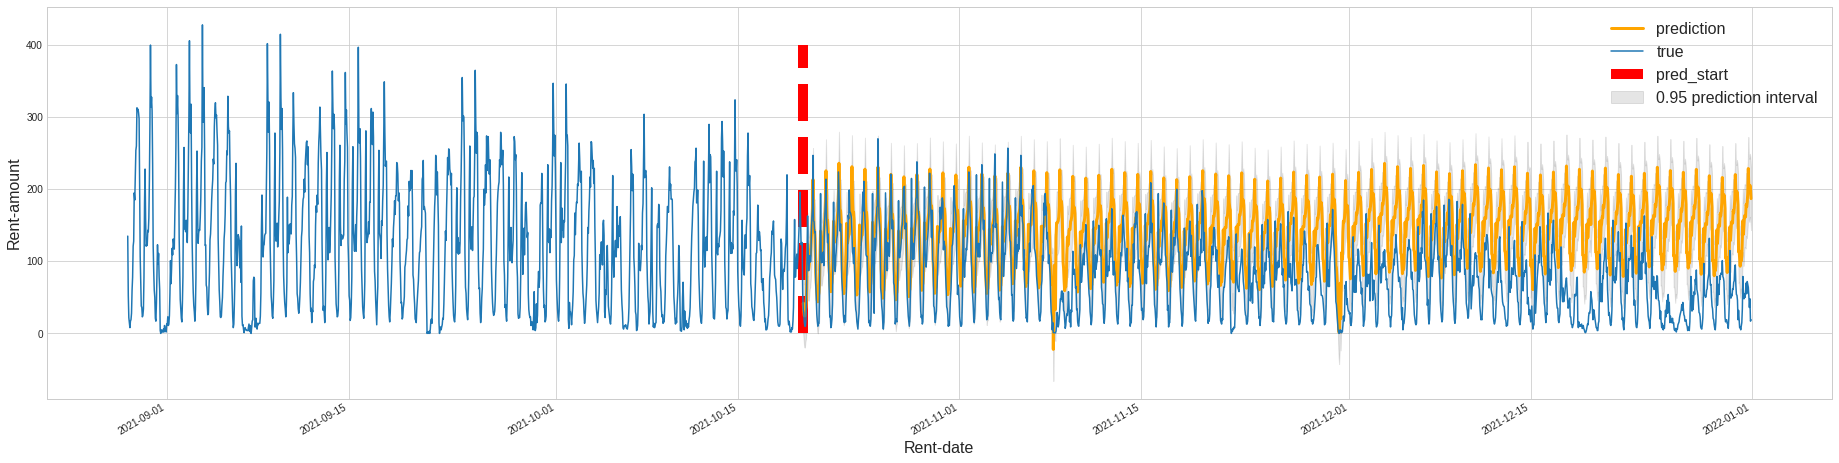

In [14]:
## 1시간전 대여량 미반영

## 1년 전체
data = labeled_input_bike_df2

# 데이터 분리
X_train,X_test,y_train,y_test = train_test_split(data.iloc[:,:-2],data["대여량"],test_size=0.2,shuffle=False)

# 모델 생성
model = SARIMAX(endog = y_train,exog=X_train, order=(24,0,24),sorder=(24,0,24,24))  ##<< 임의로 선정

# 예측값 반환
predicted_value,AIC = model_prediction_v2(model,y_test)

# 시각화
draw_test_predicted_plot_v2(data["대여량"][24*30*8:],predicted_value,y_test,(32,8))

In [ ]:
import bike_data_analysis_class
from importlib import reload
## 모듈은 수정되면 reload 해주어야 반영된다고 함.
reload(bike_data_analysis_class)
from bike_data_analysis_class import bike_predict

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    대여량   No. Observations:                 7008
Model:                        SARIMAX   Log Likelihood              -35369.371
Date:                Thu, 09 Jun 2022   AIC                          70752.742
Time:                        02:40:42   BIC                          70800.725
Sample:                    01-01-2021   HQIC                         70769.275
                         - 10-19-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
대여월            1.5400      0.158      9.745      0.000       1.230       1.850
대여요일          -0.1333      0.202     -0.660      0.509      -0.529       0.263
대여시각           0.7433      0.081      9.190      0.000       0.585       0.902
대여계절           1.7288      0.349      4.947      0.000       1.044       2.414
1시간강수량        -6.1741      0.371    -16.652      0.000      -6.901      -5.447
1시간전대여량        0.8252      0.007    113.273      0.000       0.811       0.839
sigma2      1416.7641     16.783     84.417      0.000    1383.870    1449.658
===================================================================================
Ljung-Box (L1) (Q):                 518.73   Jarque-Bera (JB):              1851.79
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               3.08   Skew:                             0.30
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

AIC : 70752.74158434714
rmse score is : 29.513278518455632
r^2_score is : 0.6787068569411618


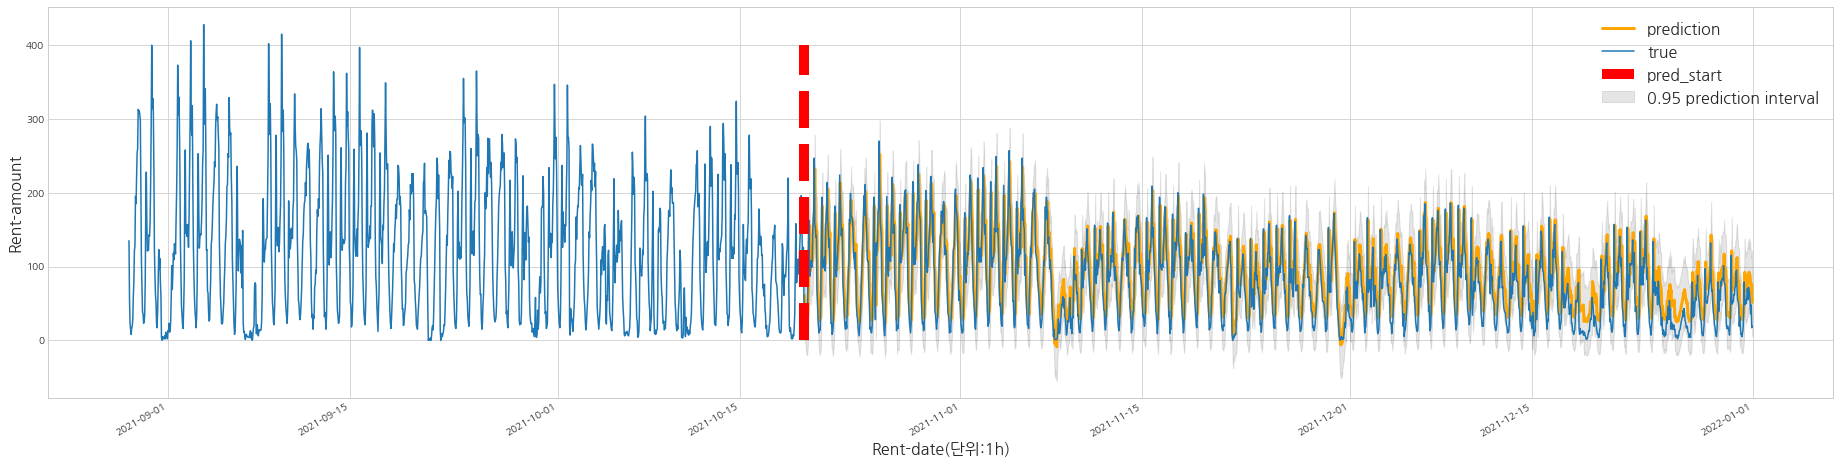

In [56]:


data = labeled_input_bike_df
X_train,X_test,y_train,y_test = train_test_split(data.iloc[:,:-1],data.iloc[:,-1],test_size=0.2,shuffle=False)
model = SARIMAX(endog = y_train,exog=X_train, order=(0,0,0),sorder=(0,0,0,24))  ## << 임의로 선정
method1 = bike_predict(data,model)
method1.model_prediction()
method1.draw_test_predicted_plot()